# Tanzanian Water Well Classification

## Overview 
For this project I will be using classification models to predict functionality of water wells in Tanzania. 

## Business Problem
Tanzania is experiencing a water crisis, meaning there is not enough fresh water resources to meet the region's basic needs. Because of this, unsanitized water is being used to drink, bathe in and wash clothes resulting in illness's like cholera. Lack of water not only affects the health of the population but also their safety and education. The Water Project wants to increase their efficiency and impact. To help them accomplish this, I'll create a model that is able to accuracte classify the status of water wells as either functional of nonfunctional. The Water Project will be able to use this classifier to see which wells need fixing, and identify areas with greater need.

## Data Understanding 
To accomplish this, I sourced data from Taarifa and the Tanzanian Ministry of Water. This dataset contains information on around 59,000 wells and 40 independent variables regarding information on geographical location, funder, management, population, quantity and quality of water, extraction type, source, if payment is required and more. The wells are classified as either 'functional', 'non functional' , or 'functional needs repair'.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from function import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix

In [2]:
df = pd.read_csv('data/train_set.csv')
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
label = pd.read_csv('data/lables.csv')
label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


Since the well status is found in a seperate dataset, I will merge the two on the 'id' coulumn.

In [4]:
df2 = pd.merge(df, label, on='id')
df2.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Data Preparation 

Before running any models, ensuring separabiity of the data is important to making accurate classifications. Below, I am checking each of the independent variables with respect to the target variable. Since our data consists of both continous and categorical data, this process will be separated in two steps. First I will look at the continous variables. 

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [13]:
continous_var = df2.select_dtypes(exclude='object').columns

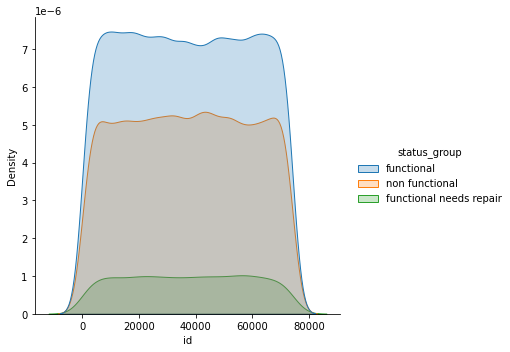

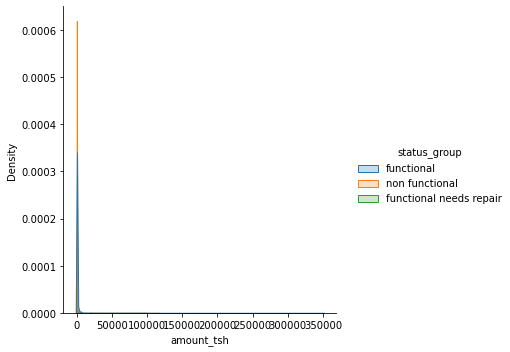

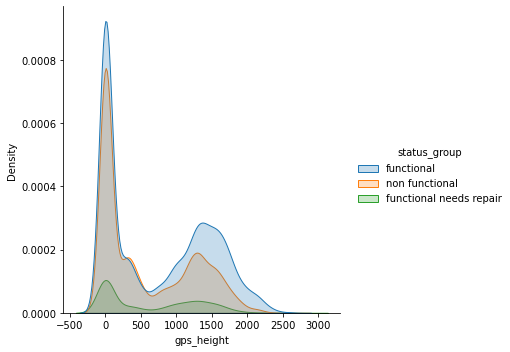

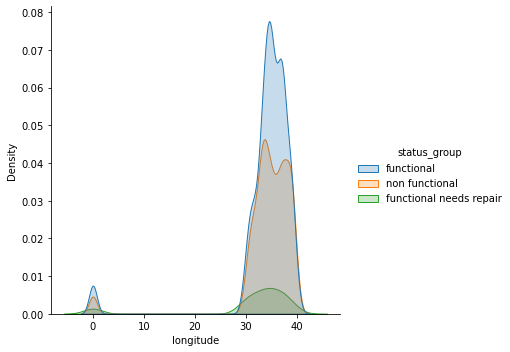

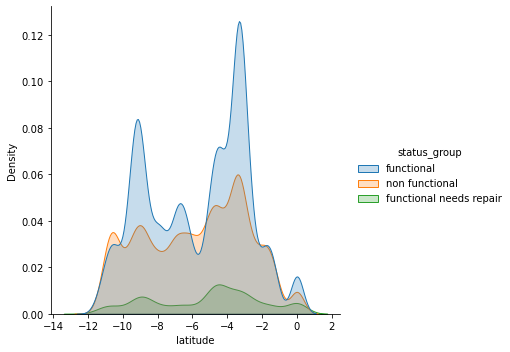

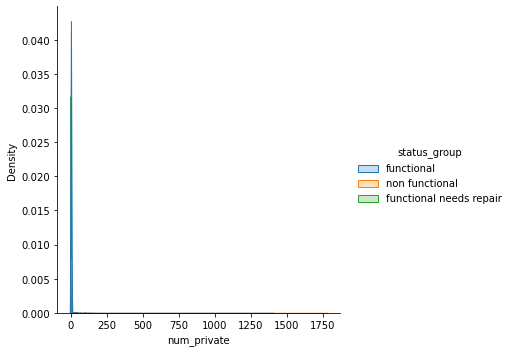

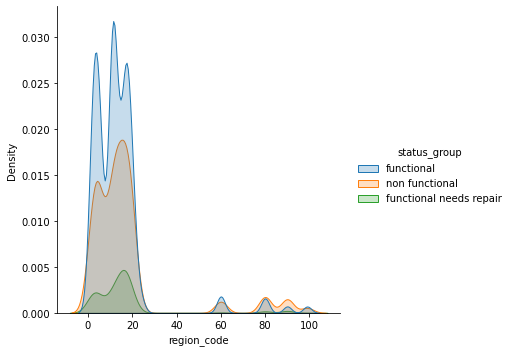

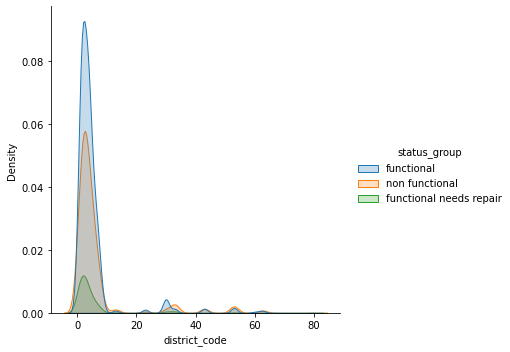

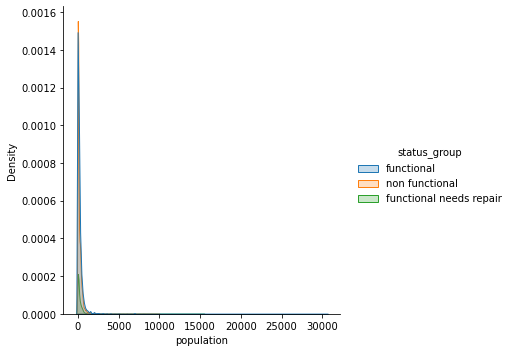

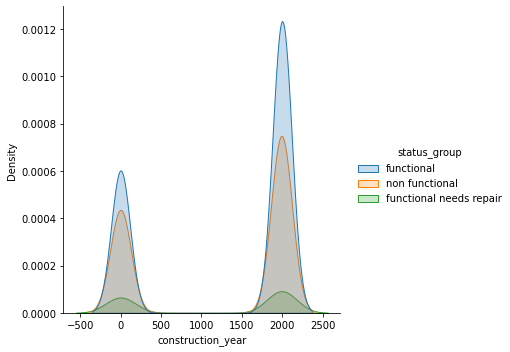

In [14]:
for column in continous_var:
    sns.displot(data=df2, x=column, hue=df2['status_group'], kind='kde', fill=True)
    plt.show()

After analyzing the graphs, I decided to not include any of the continous variables as features in the classification model. This is because there was no good separebility because function, non functional, and functional needs repair groups. Now I will look at the categorical variables.

An initial look at some of the categorical columns show that there columns with dulicate information i.e. water quality and quality group. In these cases, the more descriptive column was kept. There was also columns with over 1000 different categories i.e region and subvillage. In this case, the broader description was used. The 'recorded_by' column was also dropped because it only contained one category. 

In [37]:
remove = ['funder','installer','wpt_name','subvillage',
          'ward','scheme_name','recorded_by','extraction_type_group','payment_type',
          'quantity_group','source_type','waterpoint_type_group','quality_group']
for i in continous_var:
    remove.append(i)
remove

['funder',
 'installer',
 'wpt_name',
 'subvillage',
 'ward',
 'scheme_name',
 'recorded_by',
 'extraction_type_group',
 'payment_type',
 'quantity_group',
 'source_type',
 'waterpoint_type_group',
 'quality_group',
 'id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [42]:
train = df2.drop(columns=remove, axis=1)
train.head()

,date_recorded,basin,region,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,2011-03-14,Lake Nyasa,Iringa,Ludewa,True,VWC,False,gravity,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,2013-03-06,Lake Victoria,Mara,Serengeti,NaN,Other,True,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,2013-02-25,Pangani,Manyara,Simanjiro,True,VWC,True,gravity,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,2013-01-28,Ruvuma / Southern Coast,Mtwara,Nanyumbu,True,VWC,True,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,2011-07-13,Lake Victoria,Kagera,Karagwe,True,NaN,True,gravity,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


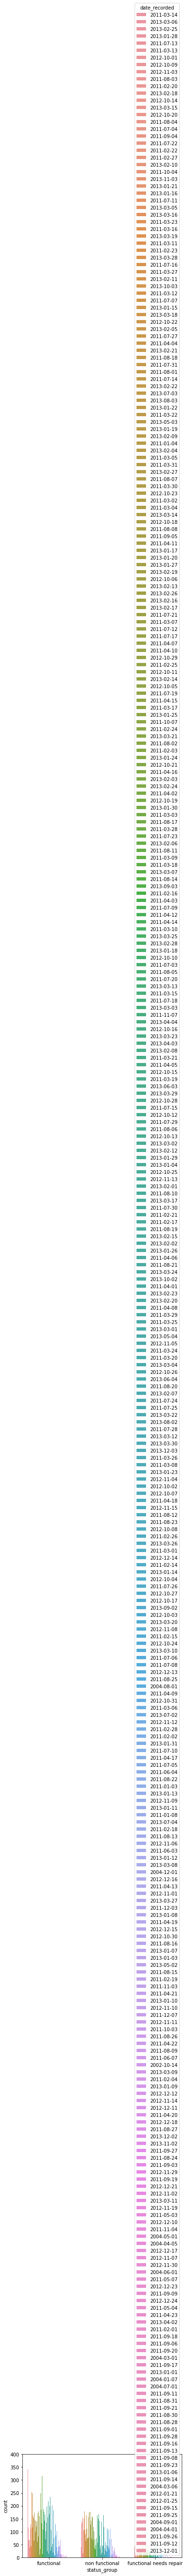

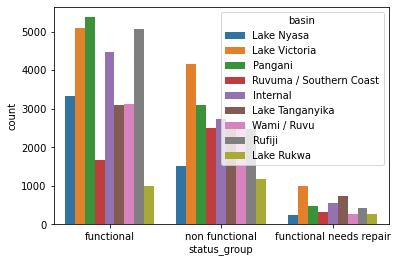

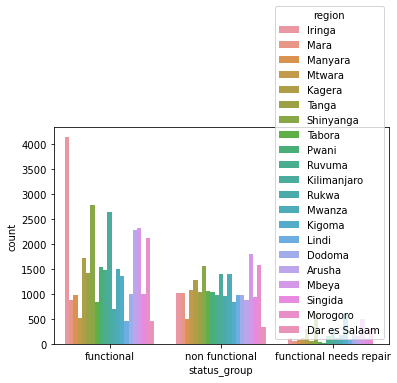

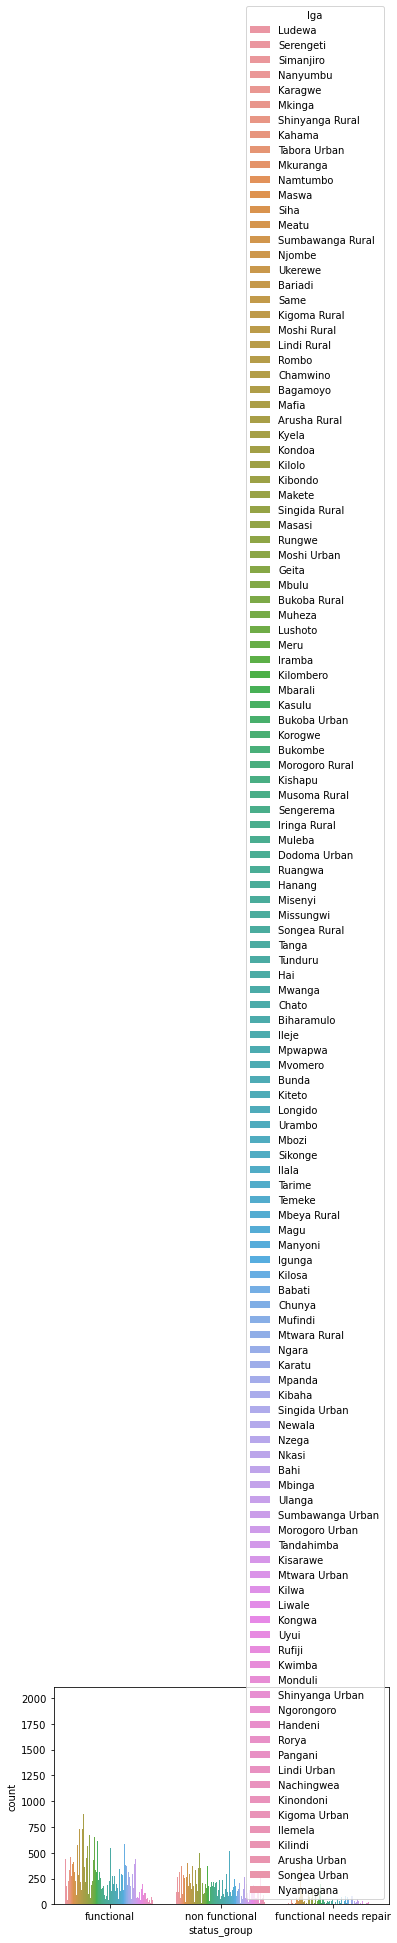

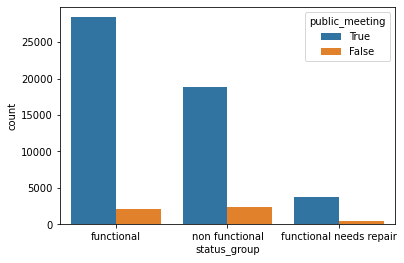

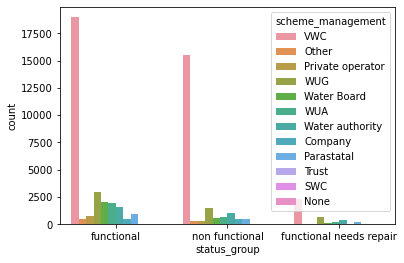

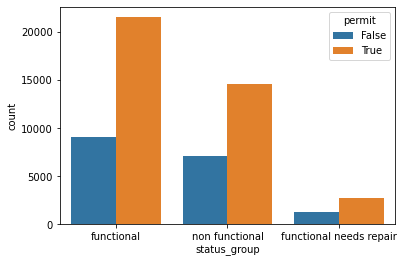

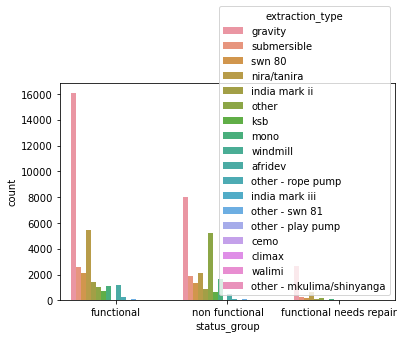

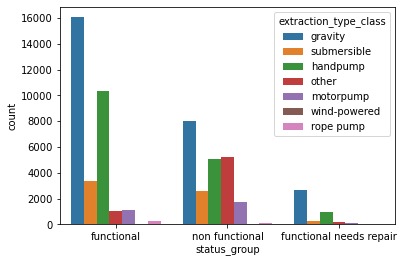

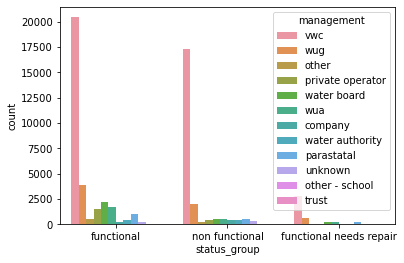

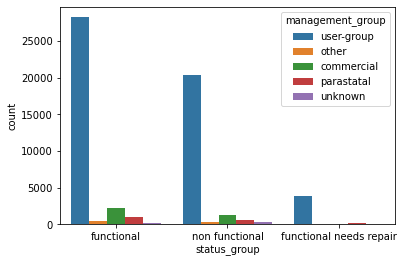

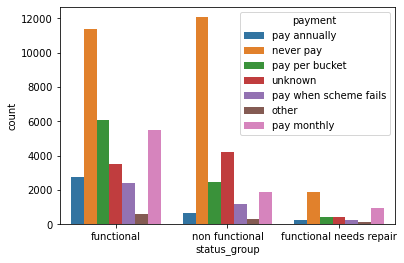

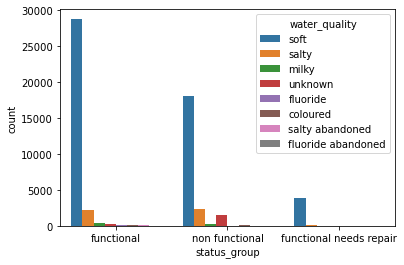

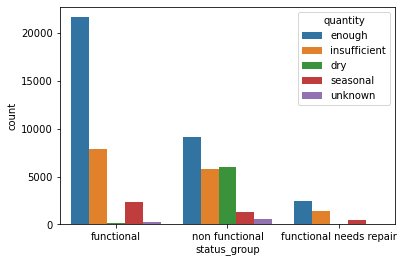

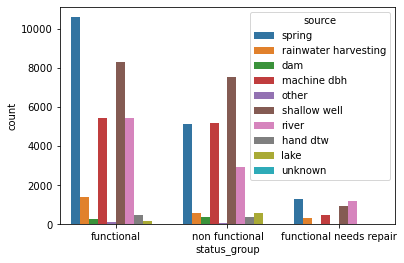

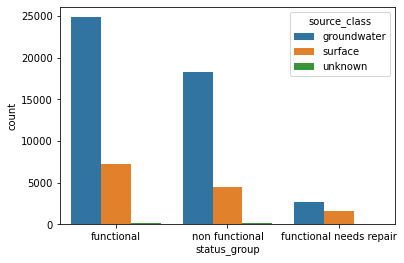

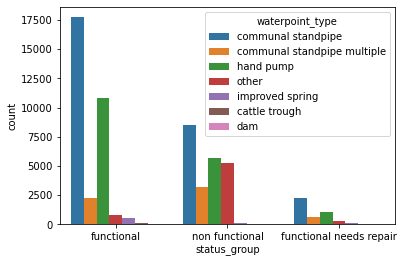

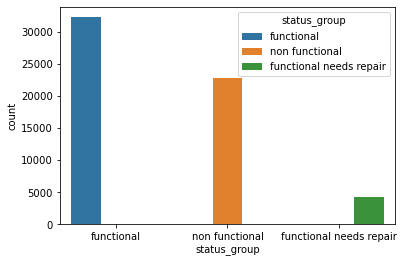

In [43]:
for column in train.columns:
    sns.countplot(data=df2, x=df2['status_group'], hue=column)
    plt.show()

All variables above show some degree in separation and are ok to use in the classification model. Now that I identified which variables will be used in the model, I will now look for null/missing values and drop them from the train dataset.

In [45]:
train.isna().sum()

date_recorded               0
basin                       0
region                      0
lga                         0
public_meeting           3334
scheme_management        3877
permit                   3056
extraction_type             0
extraction_type_class       0
management                  0
management_group            0
payment                     0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type             0
status_group                0
dtype: int64

In [46]:
train = train.dropna()

In [47]:
#checking that null columns were dropped 
train.isna().sum()

date_recorded            0
basin                    0
region                   0
lga                      0
public_meeting           0
scheme_management        0
permit                   0
extraction_type          0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quantity                 0
source                   0
source_class             0
waterpoint_type          0
status_group             0
dtype: int64

Something else to check for is class imbalance within the dataset. 

In [48]:
train['status_group'].value_counts(normalize=True)

functional                 0.549367
non functional             0.377019
functional needs repair    0.073614
Name: status_group, dtype: float64

From the inforamtion above, we see that 'functional' wells make up over 50% of the data and 'functional needs repair' wells only account for 7%. Before solving the class imbalance, I will run some initial models to see how to models are predicting the minority class. 

The target varibales will be changed to numberical categories to simplify the modeling process.  

In [49]:
train['status_group'] = train['status_group'].map({'functional': 0, 'non functional': 1,
                                                   'functional needs repair': 2})
train.head()

,date_recorded,basin,region,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,2011-03-14,Lake Nyasa,Iringa,Ludewa,True,VWC,False,gravity,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe,0
2,2013-02-25,Pangani,Manyara,Simanjiro,True,VWC,True,gravity,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,0
3,2013-01-28,Ruvuma / Southern Coast,Mtwara,Nanyumbu,True,VWC,True,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,1
5,2011-03-13,Pangani,Tanga,Mkinga,True,VWC,True,submersible,submersible,vwc,user-group,pay per bucket,salty,enough,other,unknown,communal standpipe multiple,0
6,2012-10-01,Internal,Shinyanga,Shinyanga Rural,True,VWC,True,swn 80,handpump,vwc,user-group,never pay,soft,enough,machine dbh,groundwater,hand pump,1


I will now seperate my independent (X) and dependent (y) variables and use pd.get_dummies on the categorical data. 

In [50]:
X = train.drop(columns=['status_group'], axis=1)
y = train['status_group']

In [51]:
X = pd.get_dummies(X)
X.head()

,date_recorded_2002-10-14,date_recorded_2004-01-07,date_recorded_2004-03-01,date_recorded_2004-03-06,date_recorded_2004-04-01,date_recorded_2004-04-05,date_recorded_2004-05-01,date_recorded_2004-09-01,date_recorded_2004-12-01,date_recorded_2011-01-03,...,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [55]:
X.describe()

,date_recorded_2002-10-14,date_recorded_2004-01-07,date_recorded_2004-03-01,date_recorded_2004-03-06,date_recorded_2004-04-01,date_recorded_2004-04-05,date_recorded_2004-05-01,date_recorded_2004-09-01,date_recorded_2004-12-01,date_recorded_2011-01-03,...,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
count,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,...,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000,49841.000000
mean,0.000020,0.000020,0.000080,0.000020,0.000020,0.000020,0.000020,0.000040,0.000181,0.000602,...,0.756024,0.239522,0.004454,0.001685,0.497141,0.115066,0.000120,0.277884,0.013864,0.094240
std,0.004479,0.004479,0.008958,0.004479,0.004479,0.004479,0.004479,0.006335,0.013437,0.024527,...,0.429483,0.426796,0.066591,0.041019,0.499997,0.319105,0.010971,0.447960,0.116928,0.292165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Train/Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Data Modeling - Vanilla Models 

I will now run 4 different classification models to see which preforms the best on the data. Of these 4, I will then pick the top two and tune the hyperparameters to increase accuracy.

**Logistic Regression:**

Classification report for training data:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81     21876
           1       0.80      0.68      0.74     15020
           2       0.59      0.19      0.28      2976

    accuracy                           0.76     39872
   macro avg       0.71      0.59      0.61     39872
weighted avg       0.76      0.76      0.75     39872

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      5505
           1       0.79      0.69      0.73      3771
           2       0.58      0.19      0.29       693

    accuracy                           0.76      9969
   macro avg       0.71      0.59      0.61      9969
weighted avg       0.76      0.76      0.75      9969

Confusion Matrix Train:


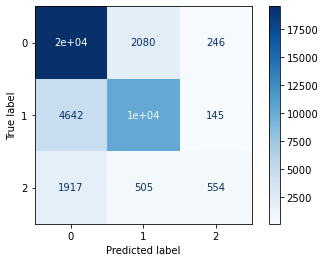

Confusion Matrix Test:


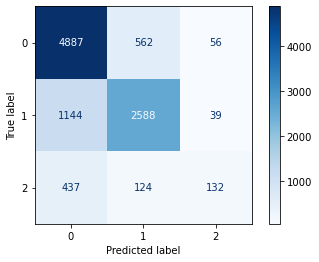

LogisticRegression(C=1000000000000.0, solver='liblinear')

In [57]:
logreg = LogisticRegression(C=1e12, solver='liblinear')
class_model(logreg, X_train, X_test, y_train, y_test)

**Analysis:** Logistic Regression gave an accuracy score of 76% for both the train and test dataset. F1 score shows that the model is doing well predicting functional and nonfunctional well but very poorly for 'functional needs repair'. This is most likely due to the class imbalance -- will try SMOTE on the train set to see if it increase evaluation metrics. 

**Decision Tree:**

Classification report for training data:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92     21876
           1       0.94      0.86      0.90     15020
           2       0.82      0.55      0.66      2976

    accuracy                           0.89     39872
   macro avg       0.88      0.79      0.82     39872
weighted avg       0.89      0.89      0.89     39872

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      5505
           1       0.82      0.75      0.78      3771
           2       0.49      0.33      0.39       693

    accuracy                           0.79      9969
   macro avg       0.70      0.65      0.67      9969
weighted avg       0.78      0.79      0.78      9969

Confusion Matrix Train:


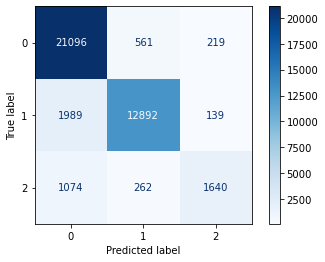

Confusion Matrix Test:


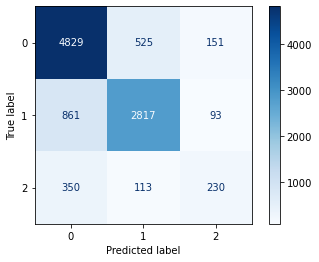

DecisionTreeClassifier()

In [53]:
d_tree = DecisionTreeClassifier()
class_model(d_tree, X_train, X_test, y_train, y_test)

**Analysis:** The decision tree model has a 89% accuracy on train set and 79% on test dataset. F1 scores are also high, still a bit low for 'functional needs repair' category but not as bad as Logistic regression model. 

Classification report for training data:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     21876
           1       0.93      0.87      0.90     15020
           2       0.78      0.60      0.67      2976

    accuracy                           0.89     39872
   macro avg       0.86      0.81      0.83     39872
weighted avg       0.89      0.89      0.89     39872

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      5505
           1       0.83      0.76      0.79      3771
           2       0.53      0.36      0.43       693

    accuracy                           0.80      9969
   macro avg       0.72      0.67      0.69      9969
weighted avg       0.80      0.80      0.80      9969

Confusion Matrix Train:


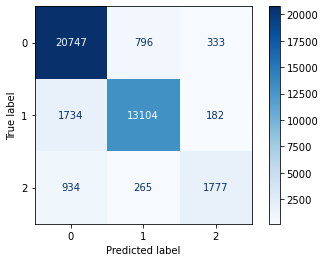

Confusion Matrix Test:


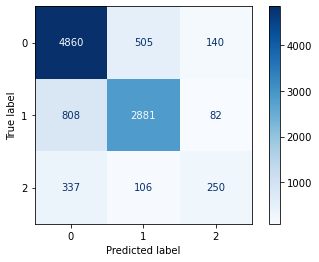

RandomForestClassifier()

In [58]:
rforest = RandomForestClassifier()
class_model(rforest, X_train, X_test, y_train, y_test)

**Analysis:** The random forest classifier had a slighly (1%) higher accuracy score compared to the decision tree. For the train set is scored 89% and for the train set it showed 80% accuracy. F1 score for functional needs repair also increased slightly, but still lower than the other two categories. 

**Gradient Boosting:** 

Classification report for training data:
              precision    recall  f1-score   support

           0       0.72      0.94      0.82     21876
           1       0.86      0.61      0.71     15020
           2       0.66      0.16      0.25      2976

    accuracy                           0.76     39872
   macro avg       0.75      0.57      0.59     39872
weighted avg       0.77      0.76      0.73     39872

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      5505
           1       0.86      0.61      0.71      3771
           2       0.62      0.18      0.28       693

    accuracy                           0.76      9969
   macro avg       0.73      0.57      0.60      9969
weighted avg       0.77      0.76      0.74      9969

Confusion Matrix Train:


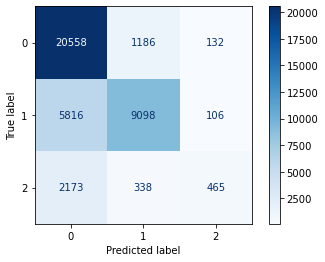

Confusion Matrix Test:


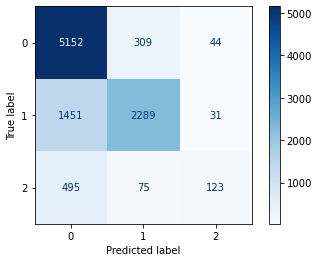

GradientBoostingClassifier(random_state=43)

In [59]:
gboost = GradientBoostingClassifier(random_state=43)
class_model(gboost, X_train, X_test, y_train, y_test)

**Analysis:** Gradiant Boosting predicted well functionality with 76% accuracy in both the train and test set. Based on these four initial models, I will be tuning hyperparamters using GridSearch on the Decision Tree and Random Forest Classifier to try and increase accuracy. 

### SMOTE
Before runing more models, I will try to solve for the class imbalance in the dataset because all the initial modes were not able to accurately and precisely predict functional needs repair category. 

In [60]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
print(pd.Series(y_train_resampled).value_counts()) 

2    21876
1    21876
0    21876
Name: status_group, dtype: int64


Classification report for training data:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     21876
           1       0.95      0.89      0.92     21876
           2       0.92      0.95      0.94     21876

    accuracy                           0.92     65628
   macro avg       0.92      0.92      0.92     65628
weighted avg       0.92      0.92      0.92     65628

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5505
           1       0.81      0.75      0.78      3771
           2       0.37      0.48      0.42       693

    accuracy                           0.77      9969
   macro avg       0.66      0.68      0.67      9969
weighted avg       0.78      0.77      0.78      9969

Confusion Matrix Train:


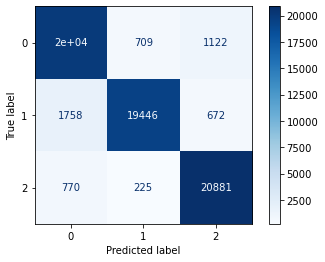

Confusion Matrix Test:


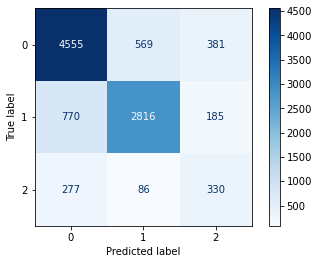

DecisionTreeClassifier()

In [61]:
d_tree_s = DecisionTreeClassifier()
class_model(d_tree_s, X_train_resampled, X_test, y_train_resampled, y_test)

After using SMOTE to balance out the different classes and running the Decision Tree Classifier again, we see the model is overfitting to the train dataset. This can be seen in the accuracy scores. There is a big differece on how the model is preforming on the train set (92% accuracy) and test set (77% accuracy). In the test set the model was able to precisely predict about 100 more 'functional needs repair' wells; however, I think it will be more beneficial to the model to drop the category completely. 

In [62]:
train.head()

,date_recorded,basin,region,lga,public_meeting,scheme_management,permit,extraction_type,extraction_type_class,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,2011-03-14,Lake Nyasa,Iringa,Ludewa,True,VWC,False,gravity,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe,0
2,2013-02-25,Pangani,Manyara,Simanjiro,True,VWC,True,gravity,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,0
3,2013-01-28,Ruvuma / Southern Coast,Mtwara,Nanyumbu,True,VWC,True,submersible,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,1
5,2011-03-13,Pangani,Tanga,Mkinga,True,VWC,True,submersible,submersible,vwc,user-group,pay per bucket,salty,enough,other,unknown,communal standpipe multiple,0
6,2012-10-01,Internal,Shinyanga,Shinyanga Rural,True,VWC,True,swn 80,handpump,vwc,user-group,never pay,soft,enough,machine dbh,groundwater,hand pump,1


Below, I will remove the '2' category from the dataset, then preform the same preprocessing steps as above. 

In [63]:
need_repair = train[train['status_group']==2].index
new_train = train.drop(need_repair)

In [64]:
new_train['status_group'].value_counts(normalize=True)

0    0.593022
1    0.406978
Name: status_group, dtype: float64

In [65]:
X = new_train.drop(columns=['status_group'], axis=1)
y = new_train['status_group']

In [66]:
X = pd.get_dummies(X)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=42)

Classification report for training data:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     21837
           1       0.96      0.87      0.91     15100

    accuracy                           0.93     36937
   macro avg       0.93      0.92      0.93     36937
weighted avg       0.93      0.93      0.93     36937

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5544
           1       0.82      0.76      0.79      3691

    accuracy                           0.84      9235
   macro avg       0.84      0.83      0.83      9235
weighted avg       0.84      0.84      0.84      9235

Confusion Matrix Train:


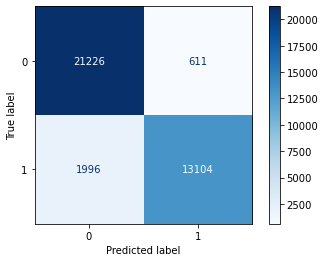

Confusion Matrix Test:


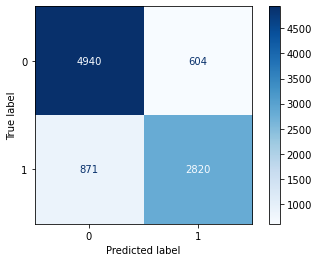

DecisionTreeClassifier()

In [68]:
d_tree = DecisionTreeClassifier()
class_model(d_tree, X_train, X_test, y_train, y_test)

**Analysis:** There is less overfitting in this model and accuracy for both train and test has increased. Since there is still some imbalance in the dataset, I want to try SMOTE one more time on this new dataset to see if it beneficial. 

In [74]:
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)
print(pd.Series(y_train_resampled).value_counts()) 

1    21837
0    21837
Name: status_group, dtype: int64


Classification report for training data:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     21837
           1       0.96      0.91      0.93     21837

    accuracy                           0.94     43674
   macro avg       0.94      0.94      0.94     43674
weighted avg       0.94      0.94      0.94     43674

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      5544
           1       0.82      0.77      0.79      3691

    accuracy                           0.84      9235
   macro avg       0.83      0.83      0.83      9235
weighted avg       0.84      0.84      0.84      9235

Confusion Matrix Train:


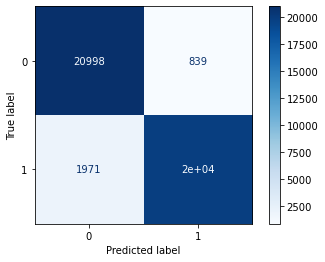

Confusion Matrix Test:


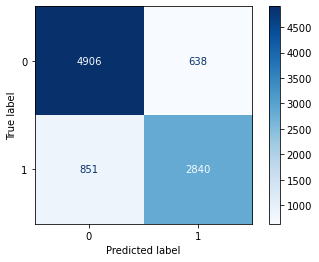

DecisionTreeClassifier()

In [75]:
d_tree_s = DecisionTreeClassifier()
class_model(d_tree_s, X_train_resampled, X_test, y_train_resampled, y_test)

**Analysis:** Comparing the two models above, the model using balanced dataset preformed better than the original. It reduced Type II error (predicting a functional well when the well is non functional) which is more beneficial to the business case than the opposite. 

## Hyperparameter Tuning 

**Decision Tree:**

In [73]:
dt_param_grid = {'criterion': ['gini','entropy'],
                 'max_depth': [None, 2,4,5,6,10],
                 'min_samples_split': [2,5,10],
                 'min_samples_leaf': [1,2,3,4,5,6]
}

In [76]:
dt_grid_search = GridSearchCV(d_tree, dt_param_grid, cv=3, return_train_score=True)
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 5, 6, 10],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [77]:
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Classification report for training data:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     21837
           1       0.96      0.91      0.93     21837

    accuracy                           0.94     43674
   macro avg       0.94      0.94      0.94     43674
weighted avg       0.94      0.94      0.94     43674

Classification report for testing data:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      5544
           1       0.81      0.77      0.79      3691

    accuracy                           0.84      9235
   macro avg       0.83      0.82      0.83      9235
weighted avg       0.84      0.84      0.84      9235

Confusion Matrix Train:


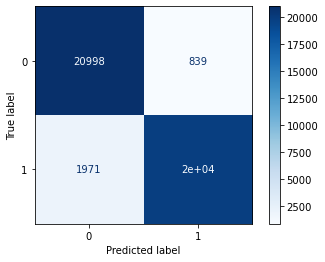

Confusion Matrix Test:


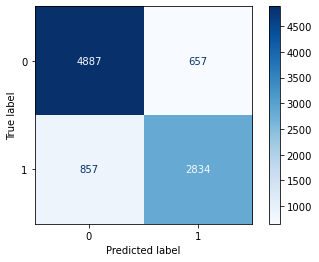

DecisionTreeClassifier()

In [78]:
d_tree1 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2)
class_model(d_tree1, X_train_resampled, X_test, y_train_resampled, y_test)

**Analysis:** Most of the evaluation metrics stayed the same between this model and original vanilla model. 

**Random Forest:**

In [79]:
rf_param_grid = {'max_depth': [None, 2,4,5],
                 'n_estimators': [10,100,350, 550],
                 'max_features': ['auto',5,10,20,30]
}

In [80]:
rf_grid_search = GridSearchCV(rforest, rf_param_grid, cv=3, return_train_score=True)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

KeyboardInterrupt: 

In [ ]:
rf_grid_search.best_params_

In [ ]:
rforest1 = RandomForestClassifier(max_depth=None, max_features=10, n_estimators=110)
class_model(rforest1, X_train_resampled, X_test, y_train_resampled, y_test)

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
plot_feature_importances(rforest1)

In [ ]:
def get_important_feat(model):
    importance = pd.DataFrame(model.feature_importances_)
    top10 = importance.sort_values(by=0, ascending=False).head(10)
    col_names = X_train.columns[top10.index]
    return col_names

In [ ]:
get_important_feat(rforest1)